# 嘗試拉長Variational Autoencoder會有甚麼變化

加載我們需要的

In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

env: KERAS_BACKEND=tensorflow


In [2]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [3]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

原本是input -> 100  ->2 -> 100 ->784

這裡我想多幾層 變為input -> 100 -> 50  -> 2 -> 50 -> 100 ->784

In [37]:
enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(50, activation='sigmoid')
enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(50, activation='sigmoid')
dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [38]:
x = Input(shape=(784,))
enc_x = enc_1(x)
enc_x = enc_2(enc_x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [39]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [40]:
dec_x = dec_3(z)
dec_x = dec_2(dec_x)
x_hat = dec_1(dec_x)

In [41]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 100)          78500       input_4[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 50)           5050        dense_13[0][0]                   
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 2)            102         dense_14[0][0]                   
__________________________________________________________________________________________________
dense_16 (

In [42]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [43]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [46]:
VAE.fit(x_train, x_train, batch_size=100, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
60000/60000 [==============================] - 6s 96us/step - loss: 216.5982
Epoch 2/20
60000/60000 [==============================] - 4s 66us/step - loss: 197.8385
Epoch 3/20
60000/60000 [==============================] - 4s 65us/step - loss: 193.3468
Epoch 4/20
60000/60000 [==============================] - 4s 66us/step - loss: 190.8571
Epoch 5/20
60000/60000 [==============================] - 4s 63us/step - loss: 188.9513
Epoch 6/20
60000/60000 [==============================] - 4s 64us/step - loss: 186.6271
Epoch 7/20
60000/60000 [==============================] - 4s 65us/step - loss: 181.7099
Epoch 8/20
60000/60000 [==============================] - 4s 66us/step - loss: 174.2203
Epoch 9/20
60000/60000 [==============================] - 4s 63us/step - loss: 171.2095
Epoch 10/20
60000/60000 [==============================] - 4s 63us/step - loss: 168.7002
Epoch 11/20
60000/60000 [==============================] - 4s 63us/step

In [47]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 102       
Total params: 83,652
Trainable params: 83,652
Non-trainable params: 0
_________________________________________________________________


In [49]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(dec_3(h_input))))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_18 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_19 (Dense)             (None, 784)               79184     
Total params: 84,434
Trainable params: 84,434
Non-trainable params: 0
_________________________________________________________________


In [50]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

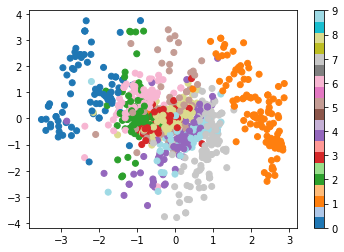

In [51]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

從上圖是我看到差異最大的地方，點的密集程度沒有助教在上課時做的密集。

In [52]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [53]:
n =15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

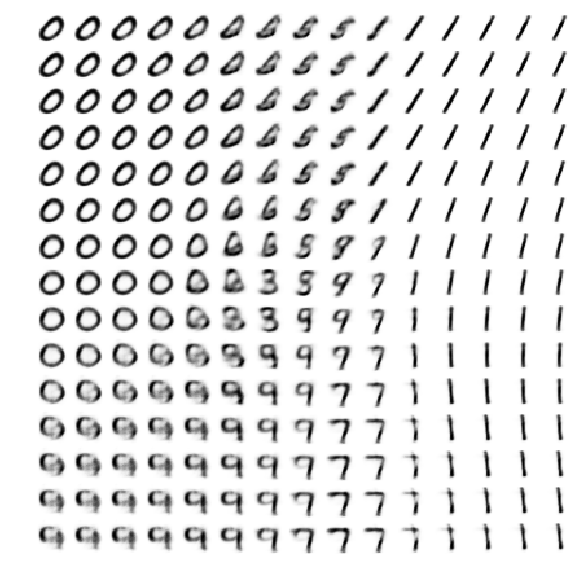

In [54]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [55]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [56]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]


In [58]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>

# 結論